## Using NFNull

In [11]:
import torch
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from nfnull import NFNull

def gmm_xdf(x, locs, scales, ws, sf=False):
    """ 
    Gaussian mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    for i in range(len(locs)):
        pdfs += ws[i] * scipy.stats.norm.pdf(x, loc=locs[i], scale=scales[i])
        if sf:
            cdfs += ws[i] * scipy.stats.norm.sf(x, loc=locs[i], scale=scales[i])
        else:
            cdfs += ws[i] * scipy.stats.norm.cdf(x, loc=locs[i], scale=scales[i])        
    return pdfs, cdfs

def expuu_xdf(x, ws, rate=3, a0=0, b0=10, a1=9, b1=10, sf=False):
    """ 
    Exponential / Uniform mixture model
    """
    pdfs = np.zeros(len(x))
    cdfs = np.zeros(len(x))
    pdfs = ws[0] * scipy.stats.expon.pdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.pdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.pdf(x, loc=a1, scale=b1)
    if sf:
     cdfs = ws[0] * scipy.stats.expon.sf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.sf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.sf(x, loc=a1, scale=b1)    
    else:
     cdfs = ws[0] * scipy.stats.expon.cdf(x, loc=0, scale=1/rate) + \
        ws[1] * scipy.stats.uniform.cdf(x, loc=a0, scale=b0) + \
        ws[2] * scipy.stats.uniform.cdf(x, loc=a1, scale=b1)
    return pdfs, cdfs


def symm_diff(x, y):
    if (x > 0.5) and (y > 0.5):
        return (1-x) / (1-y)
    else:
        return x/y

def ecdf(x):
    x = np.sort(x)
    n = len(x)
    def _ecdf(v):
        # side='right' because we want Pr(x <= v)
        return (np.searchsorted(x, v, side='right') + 1) / n
    return _ecdf

## General features of NFNull

`NFNull` models are trained by calling `fit_pdf()`, which trains the underlying normalizing flow. After training, the CDF can be accessed by `get_cdf()` (which is evaluated through Monte Carlo integration over a grid). Sampling is performed by `sample()` and p-values for a given data point are obtained by `p_value()` (again via Monte Carlo integration). 

Below, we consider 3 exemplar simulations: the standard normal distribution (the same as the base distribution), a trimodal mixture of Gaussian distributions and a skew mixture of an exponential and 2 uniform distributions. In each case, we train the model with only 500 samples and compare model p-values, CDF and PDF to the original data generating process.

### Map the normal distribution to itself

In [30]:
x = scipy.stats.norm.rvs(size=500)
nfn = NFNull(x)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {scipy.stats.norm.sf(4.9)}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 11.778709411621094, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 3.3312792778015137, best = 11.778709411621094
Patience counter: 0/5
Epoch 2: mean loss = 1.7590997219085693, best = 3.3312792778015137
Patience counter: 0/5
Epoch 3: mean loss = 1.8551645278930664, best = 1.7590997219085693
Patience counter: 0/5
Epoch 4: mean loss = 1.8594632148742676, best = 1.7590997219085693
Patience counter: 1/5
Epoch 5: mean loss = 1.7303059101104736, best = 1.7590997219085693
Patience counter: 2/5
Epoch 6: mean loss = 1.6568690538406372, best = 1.7303059101104736
Patience counter: 0/5
Epoch 7: mean loss = 1.6127793788909912, best = 1.6568690538406372
Patience counter: 0/5
Epoch 8: mean loss = 1.583890438079834, best = 1.6127793788909912
Patience counter: 0/5
Epoch 9: mean loss = 1.5585993528366089, best = 1.583890438079834
Patience counter: 0/5
Epoch 10: mean loss = 1.5484340190887451, best = 1.5585993528366089
Patience counter: 0/5
Epoch 11: mean loss = 1.5216095447540

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/411524426.py:46: RuntimeWarning: divide by zero encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/2310598153.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


<Figure size 640x480 with 0 Axes>

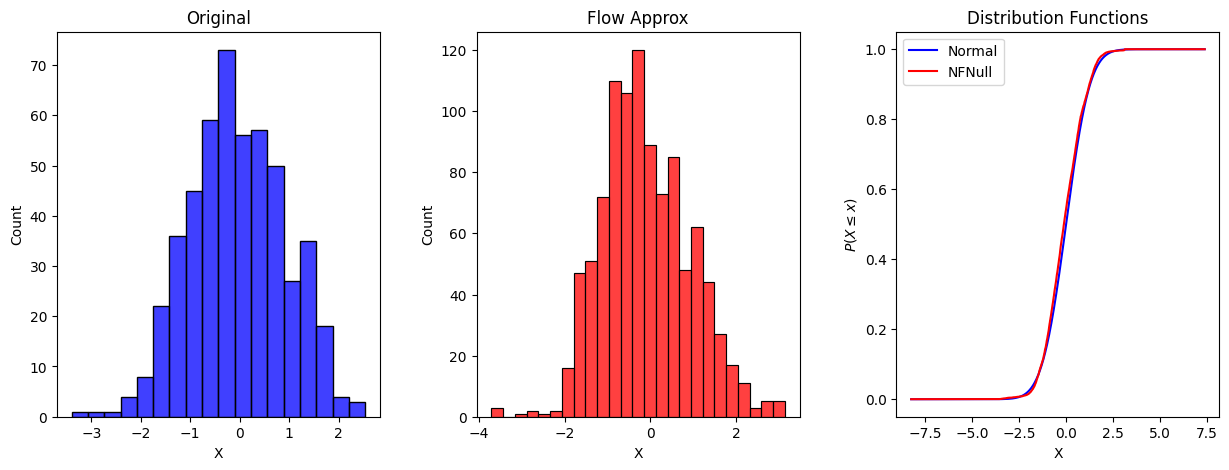

In [31]:
nfcdf = nfn.get_cdf()
x_cdf = scipy.stats.norm.cdf(nfn.grid)
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Normal CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)]))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
x_hat = nfn.sample(n=1000)

sns.histplot(x=x, ax=ax[0], color='b').set(title='Original')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r').set(title='Flow Approx')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Normal CDF', ax=ax[2], color='blue', label='Normal').set(title='Distribution Functions')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()

### Trimodal distribution

Here the target is $x \sim 0.3\cdot N(-1, 0.25) + 0.3\cdot N(0, 0.25) + 0.4\cdot N(1.5, 0.25)$.

These are a non-uniform mixture of different means, with a constant variance.

In [36]:
## generate trimodal distribution
x = np.concatenate((
    scipy.stats.norm.rvs(loc=-1, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=0, scale=0.25, size=150),
    scipy.stats.norm.rvs(loc=1.5, scale=0.25, size=200)
))
nfn = NFNull(x, prescaled=False)
nfn.fit_pdf(verbose=True, patience=5)

print(f"Analytic p-value: {gmm_xdf([4.9], [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4], sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > 4.9)}")
print(f"Neural approx: {nfn.p_value(4.9)}")

Epoch 0: mean loss = 10.655787467956543, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 6.812228202819824, best = 10.655787467956543
Patience counter: 0/5
Epoch 2: mean loss = 3.760681629180908, best = 6.812228202819824
Patience counter: 0/5
Epoch 3: mean loss = 2.178079128265381, best = 3.760681629180908
Patience counter: 0/5
Epoch 4: mean loss = 2.440549850463867, best = 2.178079128265381
Patience counter: 0/5
Epoch 5: mean loss = 2.236063003540039, best = 2.178079128265381
Patience counter: 1/5
Epoch 6: mean loss = 1.963059425354004, best = 2.178079128265381
Patience counter: 2/5
Epoch 7: mean loss = 1.8604001998901367, best = 1.963059425354004
Patience counter: 0/5
Epoch 8: mean loss = 1.7418553829193115, best = 1.8604001998901367
Patience counter: 0/5
Epoch 9: mean loss = 1.6356068849563599, best = 1.7418553829193115
Patience counter: 0/5
Epoch 10: mean loss = 1.5349761247634888, best = 1.6356068849563599
Patience counter: 0/5
Epoch 11: mean loss = 1.4304418563842773, best 

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/411524426.py:46: RuntimeWarning: invalid value encountered in scalar divide
  return (1-x) / (1-y)
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/480407704.py:9: RuntimeWarning: divide by zero encountered in log10
  'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/480407704.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


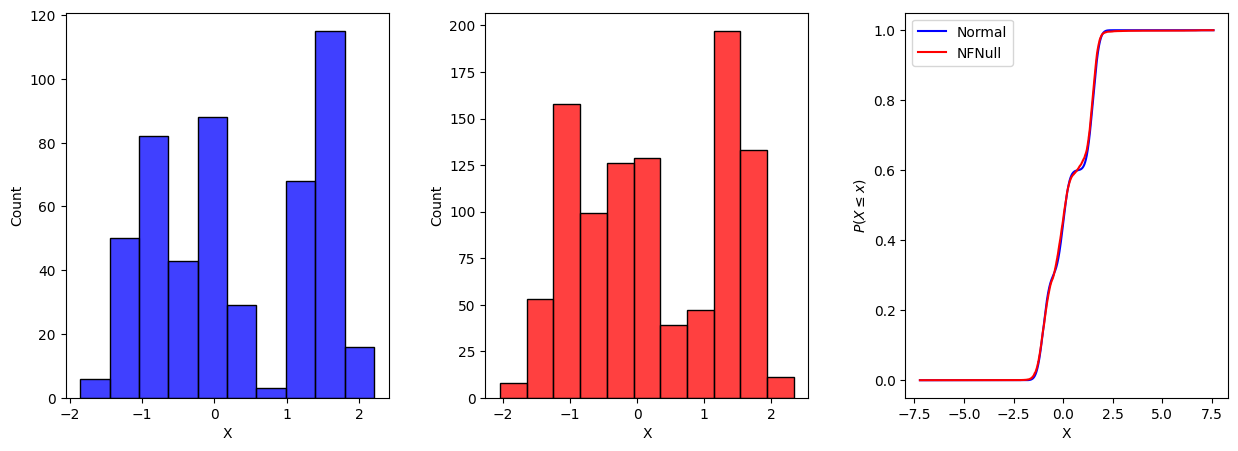

In [37]:
x_pdf, x_cdf = gmm_xdf(nfn.grid, [-1, 0, 1.5], [0.25]*3, [0.3, 0.3, 0.4])
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
nfcdf = nfn.get_cdf()
plt.subplots_adjust(wspace=0.3)
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

x_hat = nfn.sample(n=1000)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Normal')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='NFNull')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()


### Exponential / Uniform Mixture

Here the target is $x \sim 0.86\cdot Exp(3) + 0.1\cdot U(0, 10) + 0.04\cdot U(9,10)$.

The 2 uniforms both add skewness and the 2nd uniform adds a small mode far from the main one.

In [46]:
x = torch.cat((
    torch.distributions.exponential.Exponential(rate=1.5).sample(torch.Size(torch.tensor([430]))), 
    torch.distributions.uniform.Uniform(low=0, high=11).sample(torch.Size(torch.tensor([50]))), 
    torch.distributions.uniform.Uniform(low=9, high=10).sample(torch.Size(torch.tensor([20]))),     
)).cpu().numpy()
nfn = NFNull(x, prescaled=False, min_support=0)
nfn.fit_pdf(verbose=True, patience=5)

cts = [430, 50, 20]
w = np.array(cts)/np.sum(cts)
q = 9.6
x_hat = nfn.sample(n=1000)
x_pdf, x_cdf = expuu_xdf(nfn.grid, w, sf=True)
nfcdf = nfn.get_cdf()

print(f"Analytic p-valu: {expuu_xdf([q], w, sf=True)[1][0]}")
print(f"Empirical mean from samples {np.mean(x > q)}")
print(f"Neural approx: {nfn.p_value(q, greater_than=True)}")

Epoch 0: mean loss = 19.216426849365234, best = inf
Patience counter: 0/5
Epoch 1: mean loss = 2.354034423828125, best = 19.216426849365234
Patience counter: 0/5
Epoch 2: mean loss = 2.676443099975586, best = 2.354034423828125
Patience counter: 0/5
Epoch 3: mean loss = 0.9663302898406982, best = 2.354034423828125
Patience counter: 1/5
Epoch 4: mean loss = 0.9538530111312866, best = 0.9663302898406982
Patience counter: 0/5
Epoch 5: mean loss = 0.7315566539764404, best = 0.9538530111312866
Patience counter: 0/5
Epoch 6: mean loss = 0.5883811116218567, best = 0.7315566539764404
Patience counter: 0/5
Epoch 7: mean loss = 0.5465841293334961, best = 0.5883811116218567
Patience counter: 0/5
Epoch 8: mean loss = 0.5209344625473022, best = 0.5465841293334961
Patience counter: 0/5
Epoch 9: mean loss = 0.4917093515396118, best = 0.5209344625473022
Patience counter: 0/5
Epoch 10: mean loss = 0.46465378999710083, best = 0.4917093515396118
Patience counter: 0/5
Epoch 11: mean loss = 0.44710737466812

/var/folders/lj/q4zk1l5j4r90t1h6v4ly3r0r0000gn/T/ipykernel_99714/2946776831.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


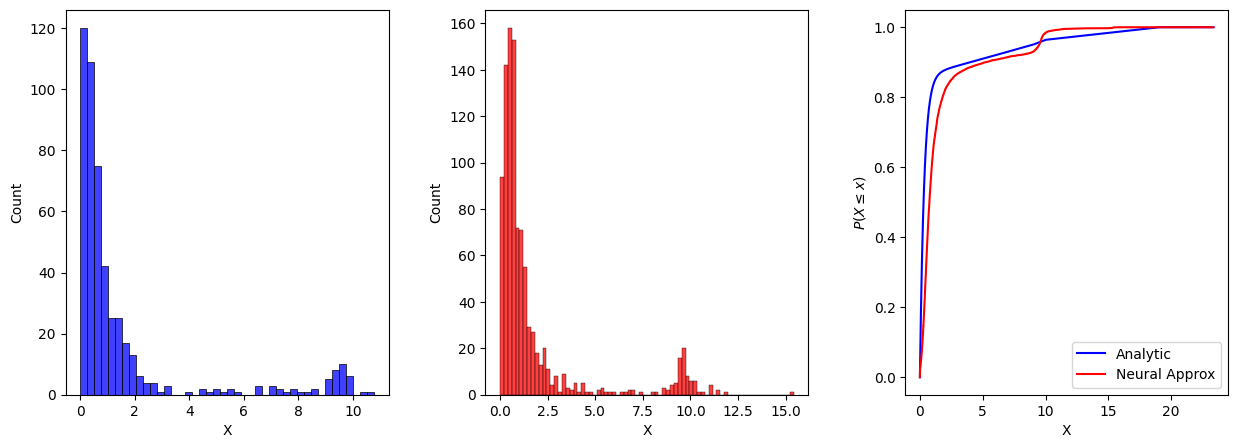

In [47]:
plot_df = pd.DataFrame({'X': nfn.grid, 
                        'Analytic CDF': 1-x_cdf,
                        'NFNull CDF': nfcdf,
                        'Diff': np.log10(np.abs(np.array([symm_diff(x, y) for x,y in zip(x_cdf, nfcdf)])))
                       })

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)
sns.histplot(x=x, ax=ax[0], color='b')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Count')
sns.histplot(x=x_hat, ax=ax[1], color='r')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Count')
sns.lineplot(data=plot_df, x='X', y='Analytic CDF', ax=ax[2], color='blue', label='Analytic')
sns.lineplot(data=plot_df, x='X', y='NFNull CDF', ax=ax[2], color='red', label='Neural Approx')
ax[2].set_xlabel('X')
ax[2].set_ylabel(r'$P(X \leq x)$')
fig.show()

## Multivariate simulations

### MVN first

In [ ]:
import numpy as np

from nfnull import NFNull
from scipy.stats import multivariate_normal

mean = [2.0, -1.0]
cov = [[2.0, 0.8], [0.8, 0.5]]
mv_normal_data = np.random.multivariate_normal(mean, cov, 1000)

model = NFNull(
    x=mv_normal_data,
    features=2,
    flow='NSF',
    passes=2,
    transforms=2,
    prescaled=False
)
model.fit_pdf(verbose=True, patience=10)

Epoch 0: mean loss = 2.991410732269287, best = inf
Patience counter: 0/10
Epoch 1: mean loss = 2.439739227294922, best = 2.991410732269287
Patience counter: 0/10
Epoch 2: mean loss = 2.3857879638671875, best = 2.439739227294922
Patience counter: 0/10
Epoch 3: mean loss = 2.351716995239258, best = 2.3857879638671875
Patience counter: 0/10
Epoch 4: mean loss = 2.357623815536499, best = 2.351716995239258
Patience counter: 0/10
Epoch 5: mean loss = 2.340059280395508, best = 2.351716995239258
Patience counter: 1/10
Epoch 6: mean loss = 2.339298725128174, best = 2.340059280395508
Patience counter: 0/10
Epoch 7: mean loss = 2.3282482624053955, best = 2.339298725128174
Patience counter: 0/10
Epoch 8: mean loss = 2.3260140419006348, best = 2.3282482624053955
Patience counter: 0/10
Epoch 9: mean loss = 2.3664939403533936, best = 2.3260140419006348
Patience counter: 0/10
Epoch 10: mean loss = 2.3595094680786133, best = 2.3260140419006348
Patience counter: 1/10
Epoch 11: mean loss = 2.363444566726

In [51]:
points = [
    [2.0, -1.0],
    [8.0, -3.0],
    [1.0, -1.0]
]

for point in points:
    print(f"P(X1 <= {point[0]} & X2 <= {point[1]})")
    print(f"-->     Flow: {model.p_value(point, n=10000, greater_than=False):.5f}")
    print(f"--> Analytic: {multivariate_normal.cdf(point, mean=[2.0, -1.0], cov=[[2.0, 0.8], [0.8, 0.5]]):.5f}")

P(X1 <= 2.0 & X2 <= -1.0)
-->     Flow: 0.42716
--> Analytic: 0.39758
P(X1 <= 8.0 & X2 <= -3.0)
-->     Flow: 0.00450
--> Analytic: 0.00234
P(X1 <= 1.0 & X2 <= -1.0)
-->     Flow: 0.24548
--> Analytic: 0.22358


In [52]:
samples = model.sample(10000)
print("Sample mean:", np.mean(samples, axis=0))
print("True mean:", mean)
print("Sample cov:", np.cov(samples.T))
print("True cov:", cov)

Sample mean: [ 1.85281937 -1.06706543]
True mean: [2.0, -1.0]
Sample cov: [[2.19343627 0.83729366]
 [0.83729366 0.51019793]]
True cov: [[2.0, 0.8], [0.8, 0.5]]


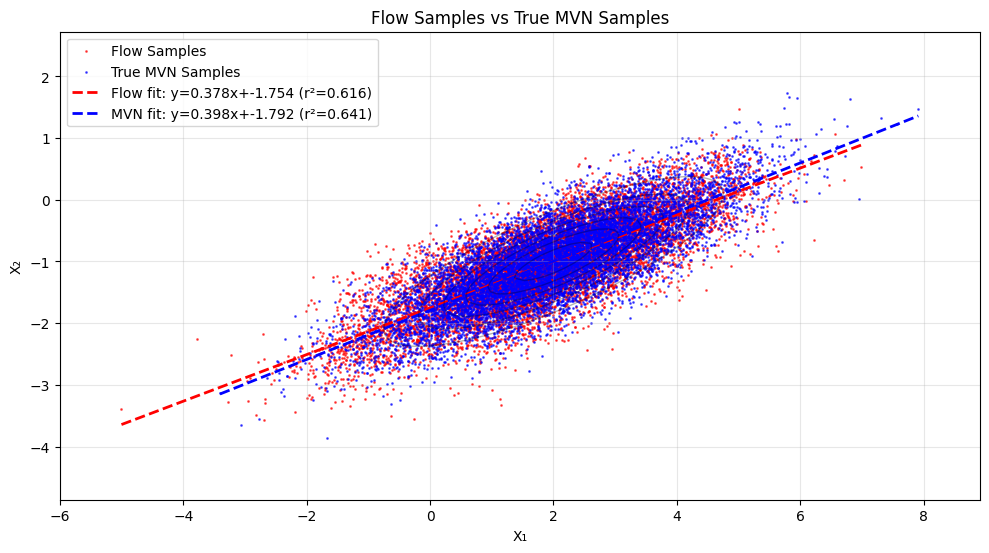

In [53]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy import stats

flow_samples = model.sample(10000)
mvn_samples = multivariate_normal.rvs(mean=mean, cov=cov, size=10000)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(flow_samples[:, 0], flow_samples[:, 1], 
          alpha=0.6, s=1, color='red', label='Flow Samples')
ax.scatter(mvn_samples[:, 0], mvn_samples[:, 1], 
          alpha=0.6, s=1, color='blue', label='True MVN Samples')

flow_slope, flow_intercept, flow_r, flow_p, flow_se = stats.linregress(flow_samples[:, 0], flow_samples[:, 1])
flow_line_x = np.array([flow_samples[:, 0].min(), flow_samples[:, 0].max()])
flow_line_y = flow_slope * flow_line_x + flow_intercept
ax.plot(flow_line_x, flow_line_y, 'red', linewidth=2, linestyle='--', 
        label=f'Flow fit: y={flow_slope:.3f}x+{flow_intercept:.3f} (r²={flow_r**2:.3f})')

mvn_slope, mvn_intercept, mvn_r, mvn_p, mvn_se = stats.linregress(mvn_samples[:, 0], mvn_samples[:, 1])
mvn_line_x = np.array([mvn_samples[:, 0].min(), mvn_samples[:, 0].max()])
mvn_line_y = mvn_slope * mvn_line_x + mvn_intercept
ax.plot(mvn_line_x, mvn_line_y, 'blue', linewidth=2, linestyle='--',
        label=f'MVN fit: y={mvn_slope:.3f}x+{mvn_intercept:.3f} (r²={mvn_r**2:.3f})')


x_range = np.linspace(min(np.min(flow_samples[:, 0]), np.min(mvn_samples[:, 0])) - 1,
                      max(np.max(flow_samples[:, 0]), np.max(mvn_samples[:, 0])) + 1, 100)
y_range = np.linspace(min(np.min(flow_samples[:, 1]), np.min(mvn_samples[:, 1])) - 1,
                      max(np.max(flow_samples[:, 1]), np.max(mvn_samples[:, 1])) + 1, 100)
X, Y = np.meshgrid(x_range, y_range)
pos = np.dstack((X, Y))
rv = multivariate_normal(mean, cov)
ax.contour(X, Y, rv.pdf(pos), colors='black', alpha=0.3, linewidths=1)

ax.set_xlabel('X₁')
ax.set_ylabel('X₂')
ax.set_title('Flow Samples vs True MVN Samples')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

### Swiss roll

Swiss roll shape: (1000, 3)
Swiss roll range X: -9.698333849135365 to 12.760586342838183
Swiss roll range Y: -0.03847697094980779 to 20.99759518961371
Swiss roll range Z: -11.203599063500754 to 14.229501310378458


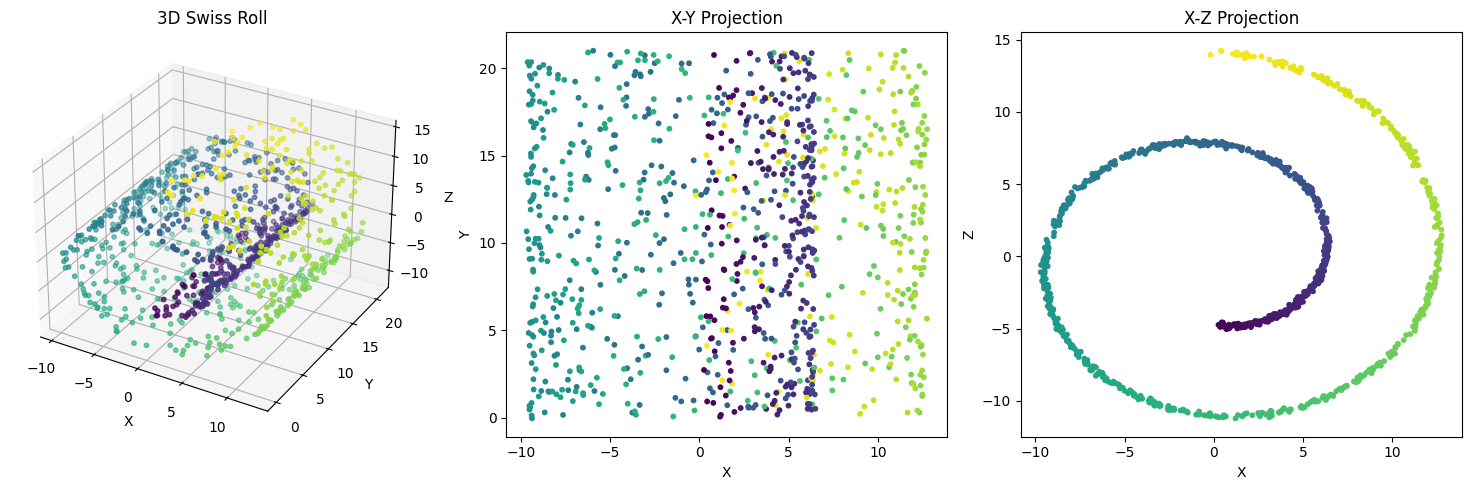

In [55]:
# 3D Swiss Roll Generation
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets import make_swiss_roll
from nfnull import NFNull

# Generate 3D Swiss Roll data
n_samples = 1000
swiss_roll_data, swiss_roll_color = make_swiss_roll(n_samples=n_samples, noise=0.1, random_state=42)

print("Swiss roll shape:", swiss_roll_data.shape)
print("Swiss roll range X:", swiss_roll_data[:, 0].min(), "to", swiss_roll_data[:, 0].max())
print("Swiss roll range Y:", swiss_roll_data[:, 1].min(), "to", swiss_roll_data[:, 1].max()) 
print("Swiss roll range Z:", swiss_roll_data[:, 2].min(), "to", swiss_roll_data[:, 2].max())

# Visualize the 3D Swiss roll
fig = plt.figure(figsize=(15, 5))

# 3D plot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], swiss_roll_data[:, 2], 
            c=swiss_roll_color, cmap='viridis', s=10)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Swiss Roll')

# 2D projections
ax2 = fig.add_subplot(132)
ax2.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], c=swiss_roll_color, cmap='viridis', s=10)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('X-Y Projection')

ax3 = fig.add_subplot(133)
ax3.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 2], c=swiss_roll_color, cmap='viridis', s=10)
ax3.set_xlabel('X')
ax3.set_ylabel('Z')
ax3.set_title('X-Z Projection')

plt.tight_layout()
plt.show()

In [74]:
# Train NFNull model on 3D Swiss Roll (following your MVN analysis structure)
swiss_model_3d = NFNull(
    x=swiss_roll_data,
    features=3,  
    flow='NSF',  
    passes=2,
    transforms=8,  
    prescaled=False,
    bins=32,
    hidden_features=(128, 128, 128, 128, 128)
)

swiss_model_3d.fit_pdf(verbose=True, patience=20, n_iter=3000)  # might need more iterations for 3D

Epoch 0: mean loss = 12.361656188964844, best = inf
Patience counter: 0/20
Epoch 1: mean loss = 4.198480606079102, best = 12.361656188964844
Patience counter: 0/20
Epoch 2: mean loss = 3.9764938354492188, best = 4.198480606079102
Patience counter: 0/20
Epoch 3: mean loss = 4.001302719116211, best = 3.9764938354492188
Patience counter: 0/20
Epoch 4: mean loss = 3.8921213150024414, best = 3.9764938354492188
Patience counter: 1/20
Epoch 5: mean loss = 3.9122040271759033, best = 3.8921213150024414
Patience counter: 0/20
Epoch 6: mean loss = 3.8314855098724365, best = 3.8921213150024414
Patience counter: 1/20
Epoch 7: mean loss = 3.8621535301208496, best = 3.8314855098724365
Patience counter: 0/20
Epoch 8: mean loss = 3.6735286712646484, best = 3.8314855098724365
Patience counter: 1/20
Epoch 9: mean loss = 3.792104959487915, best = 3.6735286712646484
Patience counter: 0/20
Epoch 10: mean loss = 3.7958943843841553, best = 3.6735286712646484
Patience counter: 1/20
Epoch 11: mean loss = 3.7342

In [75]:
def empirical_cdf_3d(data, point):
    """Compute empirical 3D CDF P(X1 <= x1 AND X2 <= x2 AND X3 <= x3)"""
    return np.mean((data[:, 0] <= point[0]) & 
                   (data[:, 1] <= point[1]) & 
                   (data[:, 2] <= point[2]))

test_points = [
    [0.0, 0.0, 0.0],     # Center region
    [5.0, 5.0, 5.0],     # One corner
    [-8.0, 0.0, -8.0],   # Edge region
    [2.0, 3.0, -3.0],    # Mixed region
    [0.0, 10.0, 0.0],    # High Y region (linear dimension)
]

print("P-value comparisons (P(X1 <= x1 & X2 <= x2 & X3 <= x3)):")
print("=" * 60)
for point in test_points:
    flow_p = swiss_model_3d.p_value(point, n=100000, greater_than=False)
    empirical_p = empirical_cdf_3d(swiss_roll_data, point)
    ratio = flow_p / empirical_p if empirical_p > 0 else float('inf')
    print(f"Point {point}:")
    print(f"-->     Flow: {flow_p:.6f}")
    print(f"--> Empirical: {empirical_p:.6f}")
    print()

P-value comparisons (P(X1 <= x1 & X2 <= x2 & X3 <= x3)):
Point [0.0, 0.0, 0.0]:
-->     Flow: 0.000780
--> Empirical: 0.000000

Point [5.0, 5.0, 5.0]:
-->     Flow: 0.113849
--> Empirical: 0.106000

Point [-8.0, 0.0, -8.0]:
-->     Flow: 0.000010
--> Empirical: 0.000000

Point [2.0, 3.0, -3.0]:
-->     Flow: 0.042760
--> Empirical: 0.037000

Point [0.0, 10.0, 0.0]:
-->     Flow: 0.104419
--> Empirical: 0.091000



In [ ]:
swiss_samples_3d = swiss_model_3d.sample(10000)

print("3D Swiss Roll Sample Statistics:")
print("=" * 40)
print("Original mean:", np.mean(swiss_roll_data, axis=0))
print("Flow mean:    ", np.mean(swiss_samples_3d, axis=0))
print("\nOriginal cov:")
print(np.cov(swiss_roll_data.T))
print("\nFlow cov:")
print(np.cov(swiss_samples_3d.T))

orig_corr = np.corrcoef(swiss_roll_data.T)
flow_corr = np.corrcoef(swiss_samples_3d.T)
print("\nOriginal correlations:")
print(orig_corr)
print("\nFlow correlations:")
print(flow_corr)

3D Swiss Roll Sample Statistics:
Original mean: [ 2.00351339 10.64759924  0.16018708]
Flow mean:     [ 2.39142022  9.66998859 -0.89908271]

Original cov:
[[43.14330482  1.61577038  6.22317039]
 [ 1.61577038 37.72396321  1.72826845]
 [ 6.22317039  1.72826845 47.68923016]]

Flow cov:
[[4.47881418e+01 7.51140125e-02 9.05235256e+00]
 [7.51140125e-02 3.58413843e+01 4.65164624e-02]
 [9.05235256e+00 4.65164624e-02 5.20749032e+01]]

Original correlations:
[[1.         0.04005108 0.13719707]
 [0.04005108 1.         0.0407467 ]
 [0.13719707 0.0407467  1.        ]]

Flow correlations:
[[1.         0.00187477 0.18744148]
 [0.00187477 1.         0.00107671]
 [0.18744148 0.00107671 1.        ]]


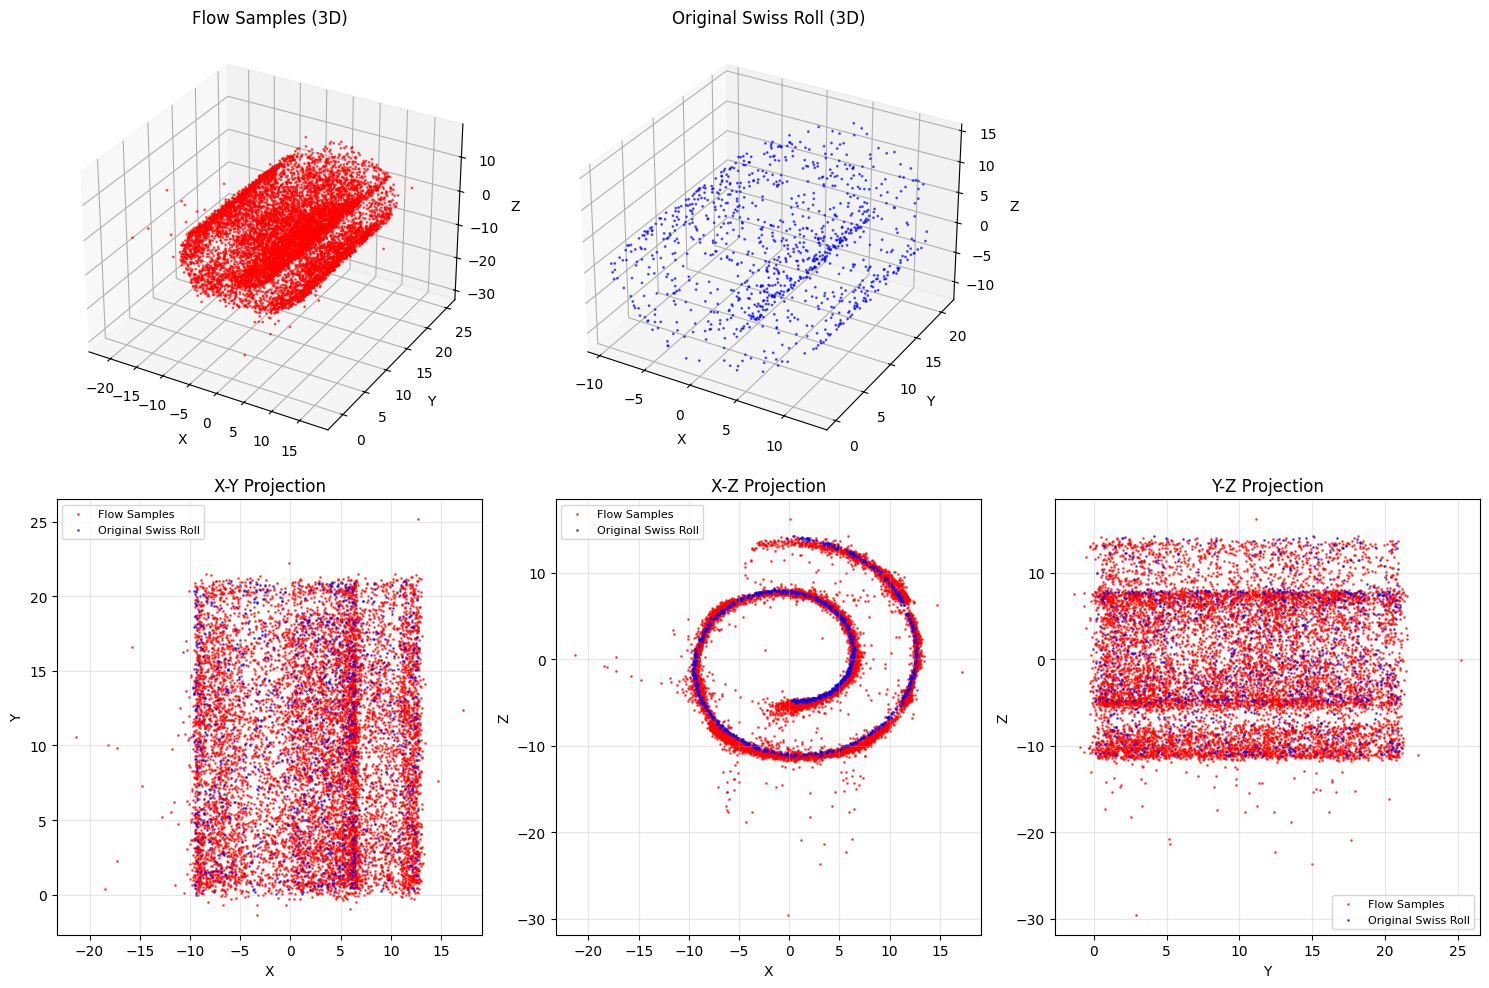

In [77]:
fig = plt.figure(figsize=(15, 10))

# 3D scatter plots
ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(swiss_samples_3d[:, 0], swiss_samples_3d[:, 1], swiss_samples_3d[:, 2], 
           alpha=0.6, s=1, color='red', label='Flow Samples')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Flow Samples (3D)')

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], swiss_roll_data[:, 2], 
           alpha=0.6, s=1, color='blue', label='Original Swiss Roll')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Original Swiss Roll (3D)')

projections = [
    (0, 1, 'X', 'Y'),  # X-Y
    (0, 2, 'X', 'Z'),  # X-Z  
    (1, 2, 'Y', 'Z')   # Y-Z
]

for i, (dim1, dim2, label1, label2) in enumerate(projections):
    ax = fig.add_subplot(2, 3, i+4)
    
    ax.scatter(swiss_samples_3d[:, dim1], swiss_samples_3d[:, dim2], 
              alpha=0.6, s=1, color='red', label='Flow Samples')
    ax.scatter(swiss_roll_data[:, dim1], swiss_roll_data[:, dim2], 
              alpha=0.6, s=1, color='blue', label='Original Swiss Roll')

    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    ax.set_title(f'{label1}-{label2} Projection')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### <span style="color:red"> TODO </span>

Need to demonstrate NFs with $t$-distribution as base distribution (`flow=TNSF`).